#  <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science 

## Homework 7: Classification with Logistic Regression, LDA/QDA, and Trees


**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">



In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the [instructions given in Canvas](https://canvas.harvard.edu/courses/42693/pages/homework-policies-and-submission-instructions).

- If needed, clarifications will be posted on Piazza.

- This homework can be submitted in pairs.

- If you submit individually but you have worked with someone, please include the name of your **one** partner below. 


**Name of the person you have worked with goes here:** Xi Han, Haoran Zhao
<br><BR>

<hr style="height:2pt">

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_blobs
from IPython.display import Image

<div class='exercise'><b> Question 1 [20 pts]: Overview of Multiclass Thyroid Classification </b></div>

In this problem set you will build a model for diagnosing disorders in a patient's thyroid gland. Given the results of medical tests on a patient, the task is to classify the patient either as:
- *normal* (class 1)
- having *hyperthyroidism* (class 2)
- or having *hypothyroidism* (class 3). 

The data set is provided in the file `dataset_hw7.csv`. Columns 1-2 contain biomarkers for a patient (predictors):
- Biomarker 1: (Logarithm of) level of basal thyroid-stimulating hormone (TSH) as measured by radioimmuno assay
- Biomarker 2: (Logarithm of) maximal absolute difference of TSH value after injection of 200 micro grams of thyrotropin-releasing hormone as compared to the basal value.

The last column contains the diagnosis for the patient from a medical expert. This data set was [obtained from the UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Thyroid+Disease); for this assignment we chose two predictors so we can visualize the decision boundaries.

Notice that unlike previous exercises, the task at hand is a 3-class classification problem. We will explore different methods for multiclass classification.

For most of this problem set, we'll measure overall classification accuracy as the fraction of observations classified correctly.



**1.1** Load the data and examine its structure. How many instances of each class are there in our dataset? In particular, what is the ratio of the number of observations in class 2 (hyperthyroidism) to the number of observations in class 3 (hypothyroidism)? We'll refer to this as the *hyper-to-hypo ratio*.

**1.2**: We're going to split this data into a 50% training set and a 50% test set. But since our dataset is small, we need to make sure we do it correctly. Let's see what happens when we *don't* split correctly: for each of 100 different random splits of the data into 50% train and 50% test, compute the hyper-to-hypo for the observations end up in the training set. Plot the distribution of the hyper-to-hypo ratio; on your plot, also mark the hyper-to-hypo ratio that you found in the full dataset. Discuss how representative the training and test sets are likely to be if we were to have selected one of these random splits.

**1.3** Now, we'll use the `stratify` option to split the data in such a way that the relative class frequencies are preserved (the code is provided). Make a table showing how many observations of each class ended up in your training and test sets. Verify that the hyper-hypo ratio is roughly the same in both sets.

**1.4** Provide the scatterplot of the predictors in the (training) data in a way that clearly indicates which class each observation belongs to.

**1.5**: When we first start working with a dataset or algorithm, it's typically a good idea to figure out what *baselines* we might compare our results to. For regression, we always compared against a baseline of predicting the mean (in computing $R^2$). For classification, a simple baseline is always predicting the *most common class*. What "baseline" accuracy can we achieve on the thyroid classification problem by always predicting the most common class? Assign the result to `baseline_accuracy` so we can use it later. (**note: don't look at the test set until instructed**)

**1.6** Make a decision function to separate these samples using no library functions; just write out your logic by hand. Your manual classifier doesn't need to be well-tuned (we'll be exploring algorithms to do that!); it only needs to (1) predict each class at least once, and (2) achieve an accuracy at least 10% greater accurate than predicting the most likely class. Use the `overlay_decision_boundaries` function provided above to overlay the decision boundaries of your function on the training set. (Note that the function modifies an existing plot, so call it after plotting your points.)

Based on your exploration, do you think a linear classifier (i.e., a classifier where all decision boundaries are line segments) could achieve above 85% accuracy on this dataset? Could a non-linear classifier do better? What characteristics of the data lead you to these conclusions?

**1.1** Load the data and examine its structure. How many instances of each class are there in our dataset? In particular, what is the ratio of the number of observations in class 2 (hyperthyroidism) to the number of observations in class 3 (hypothyroidism)? We'll refer to this as the *hyper-to-hypo ratio*.

In [3]:
df = pd.read_csv('dataset_hw7.csv')
df.head()

,Biomarker 1,Biomarker 2,Diagnosis
0,0.262372,0.875473,1
1,0.693152,0.262372,1
2,0.262372,0.405472,1
3,-0.105349,1.064714,1
4,0.000010,1.131405,1


In [4]:
num_class = df['Diagnosis'].value_counts()
hyper2hypo = num_class[2] / num_class[3]
print(num_class)
print("hyper-to-hypo ratio: %.2f" % hyper2hypo)

1    150
2     35
3     30
Name: Diagnosis, dtype: int64
hyper-to-hypo ratio: 1.17


- Number of instances in each class: 
    - class 1 (normal): 150
    - class 2 (hyperthyroidism): 35
    - class 3 (hypothyroidism): 30
    
- Hyper-to-hypo ratio is 1.17.

**1.2**: We're going to split this data into a 50% training set and a 50% test set. But since our dataset is small, we need to make sure we do it correctly. Let's see what happens when we *don't* split correctly: for each of 100 different random splits of the data into 50% train and 50% test, compute the hyper-to-hypo for the observations end up in the training set. Plot the distribution of the hyper-to-hypo ratio; on your plot, also mark the hyper-to-hypo ratio that you found in the full dataset. Discuss how representative the training and test sets are likely to be if we were to have selected one of these random splits.

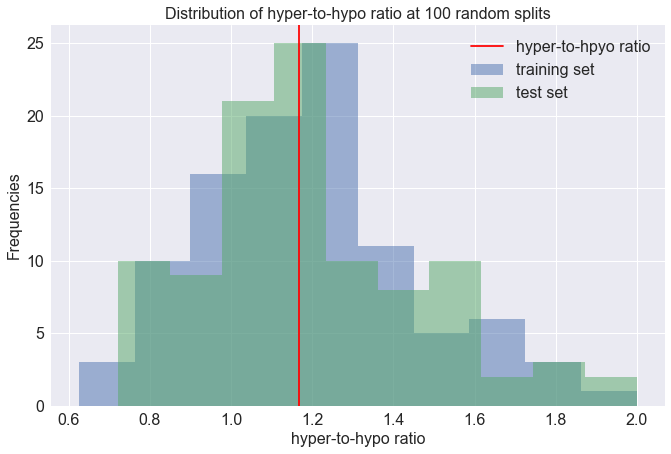

In [5]:
hyper2hypo_train = []
hyper2hypo_test = []

for i in range(100): 
    data_train, data_test = train_test_split(df, test_size=.5, random_state=i)
    
    num_class_train = data_train['Diagnosis'].value_counts()
    num_class_test = data_test['Diagnosis'].value_counts()
    hyper2hypo_train.append(num_class_train[2] / num_class_train[3])
    hyper2hypo_test.append(num_class_test[2] / num_class_test[3])

fig, ax = plt.subplots(1, 1, figsize=(11, 7))
ax.hist(hyper2hypo_train, alpha=0.5, label='training set')  
ax.hist(hyper2hypo_test, alpha=0.5, label='test set')  
ax.tick_params(labelsize=16)
ax.axvline(x=hyper2hypo, color='r', label='hyper-to-hpyo ratio')
ax.set_title('Distribution of hyper-to-hypo ratio at 100 random splits', fontsize=16)
ax.set_xlabel('hyper-to-hypo ratio', fontsize=16)
ax.set_ylabel('Frequencies', fontsize=16)
ax.legend(fontsize=16)
plt.show()

**your answer here** 

As shown above, there will be a lot of variations of the hyper-to-hypo ratio at rondom splits, if we don't stratify on the Diagnosis column. Some of the splits will result in very unrepresentative training and test sets, with ratios as low as 0.6 or as high as 2.0. 

**1.3** Now, we'll use the `stratify` option to split the data in such a way that the relative class frequencies are preserved (the code is provided). Make a table showing how many observations of each class ended up in your training and test sets. Verify that the hyper-hypo ratio is roughly the same in both sets.

In [6]:
data_train, data_test = train_test_split(df, test_size=.5, stratify=df.Diagnosis, random_state=99);

In [7]:
predictors = ['Biomarker 1', 'Biomarker 2']
X_train = data_train.loc[:,predictors]
y_train = data_train.loc[:,'Diagnosis']
X_test = data_test.loc[:,predictors]
y_test = data_test.loc[:,'Diagnosis']

In [8]:
num_class_train = data_train['Diagnosis'].value_counts()
num_class_test = data_test['Diagnosis'].value_counts()
table = pd.DataFrame({'training_set': num_class_train, 
                      'test_set': num_class_test})
table.index.name = 'class'
display(table)

,training_set,test_set
class,,
1,75,75
2,17,18
3,15,15


In [9]:
print("hyper-to-hypo ratio in full sample: %.2f" % hyper2hypo)
print("hyper-to-hypo ratio in training set: %.2f" % (num_class_train[2] / num_class_train[3]))
print("hyper-to-hypo ratio in test set: %.2f" % (num_class_test[2] / num_class_test[3]))

hyper-to-hypo ratio in full sample: 1.17
hyper-to-hypo ratio in training set: 1.13
hyper-to-hypo ratio in test set: 1.20


The hyper-hypo ratios are roughly the same in training and test sets.

**1.4** Provide the scatterplot of the predictors in the (training) data in a way that clearly indicates which class each observation belongs to.

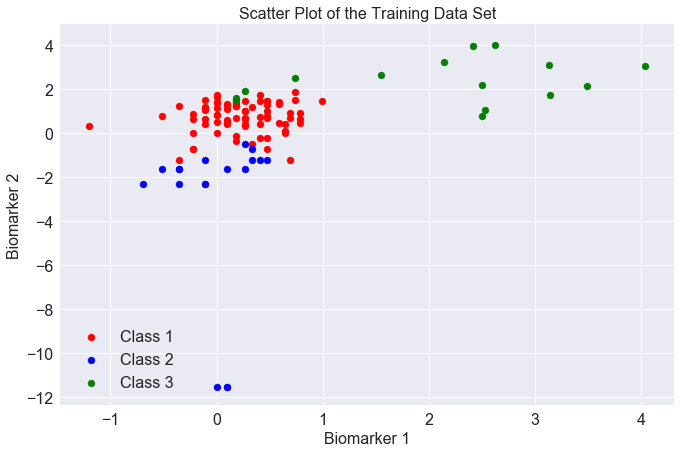

In [10]:
def scatter_plot(ax, df, cls, columns, class_labels, class_colors, title, fontsize=16):
    for idx, (color, name) in enumerate(zip(class_colors, class_labels)):
        subset = df[df[cls] == name]
        ax.scatter(
            subset[columns[0]], subset[columns[1]],
            c=color, 
            label = 'Class ' + str(int(name)))
    ax.set_title(title, fontsize=fontsize)
    ax.set_xlabel(columns[0], fontsize=fontsize)
    ax.set_ylabel(columns[1], fontsize=fontsize)
    ax.tick_params(labelsize=fontsize)
    ax.legend(loc='best', fontsize=fontsize)
    
fig, ax = plt.subplots(1, 1, figsize=(11,7))

scatter_plot(
    ax, data_train,
    cls='Diagnosis',
    columns=['Biomarker 1', 'Biomarker 2'],
    class_labels=[1, 2, 3],
    class_colors=['r', 'b', 'g'], 
    title='Scatter Plot of the Training Data Set', 
    fontsize=16    
)

**1.5**: When we first start working with a dataset or algorithm, it's typically a good idea to figure out what *baselines* we might compare our results to. For regression, we always compared against a baseline of predicting the mean (in computing $R^2$). For classification, a simple baseline is always predicting the *most common class*. What "baseline" accuracy can we achieve on the thyroid classification problem by always predicting the most common class? Assign the result to `baseline_accuracy` so we can use it later. (**note: don't look at the test set until instructed**)

In [11]:
baseline_accuracy = max(num_class_train) / sum(num_class_train)
print("Baseline accuracy by always predicting the most common class: {:.2%}".format(baseline_accuracy))

Baseline accuracy by always predicting the most common class: 70.09%


**1.6** Make a decision function to separate these samples using no library functions; just write out your logic by hand. Your manual classifier doesn't need to be well-tuned (we'll be exploring algorithms to do that!); it only needs to (1) predict each class at least once, and (2) achieve an accuracy at least 10% greater accurate than predicting the most likely class. Use the `overlay_decision_boundaries` function provided above to overlay the decision boundaries of your function on the training set. (Note that the function modifies an existing plot, so call it after plotting your points.)

Based on your exploration, do you think a linear classifier (i.e., a classifier where all decision boundaries are line segments) could achieve above 85% accuracy on this dataset? Could a non-linear classifier do better? What characteristics of the data lead you to these conclusions?

In [12]:
def overlay_decision_boundary(ax, model, colors=None, nx=200, ny=200, desaturate=.5):
    """
    A function that visualizes the decision boundaries of a classifier.
    
    ax: Matplotlib Axes to plot on
    model: Classifier (has a `.predict` method)
    X: feature vectors
    y: ground-truth classes
    colors: list of colors to use. Use color colors[i] for class i.
    nx, ny: number of mesh points to evaluated the classifier on
    desaturate: how much to desaturate each of the colors (for better contrast with the sample points)
    """
    # Create mesh
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    xx, yy = np.meshgrid(
        np.linspace(xmin, xmax, nx),
        np.linspace(ymin, ymax, ny))
    X = np.c_[xx.flatten(), yy.flatten()]

    # Predict on mesh of points
    if hasattr(model, 'predict'):
        model = model.predict
    y = model(X)
    y = y.reshape((nx, ny))

    # Generate colormap.
    if colors is None:
        colors = sns.utils.get_color_cycle()
        y -= y.min() # If first class is not 0, shift.
    assert np.max(y) <= len(colors)
    colors = [sns.utils.desaturate(color, desaturate) for color in colors]
    cmap = matplotlib.colors.ListedColormap(colors)

    # Plot decision surface
    ax.pcolormesh(xx, yy, y, zorder=-2, cmap=cmap, norm=matplotlib.colors.NoNorm(), vmin=0, vmax=y.max() + 1)
    xx = xx.reshape(nx, ny)
    yy = yy.reshape(nx, ny)
#     ax.contourf(xx, yy, y, cmap=cmap, vmin=0, vmax=3)
    ax.contour(xx, yy, y, colors="black", linewidths=1, zorder=-1)

In [13]:
def predict_manual_one_sample(x):
    if x[0] > 1: 
        return 3
    
    if x[1] < -1.5: 
        return 2
    
    return 1

In [14]:
def predict_manual(X):
    return np.array([predict_manual_one_sample(x) for x in X])

manual_predictions = predict_manual(X_train.values)
accuracy = accuracy_score(y_train, manual_predictions)
print("Accuracy:", accuracy)

Accuracy: 0.897196261682243


In [15]:
assert accuracy >= (baseline_accuracy * 1.10), "Accuracy too low"
assert all(np.sum(manual_predictions == i) > 0 for i in [1, 2, 3]), "Should predict each class at least once."

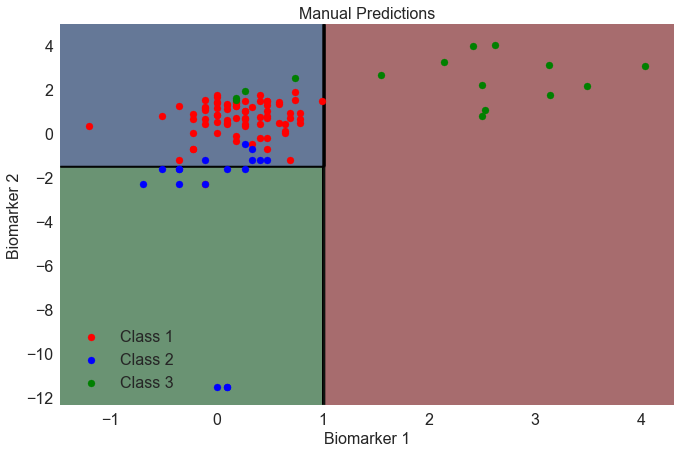

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(11,7))

scatter_plot(
    ax, data_train,
    cls='Diagnosis',
    columns=['Biomarker 1', 'Biomarker 2'],
    class_labels=[1, 2, 3],
    class_colors=['r', 'b', 'g'], 
    title='Manual Predictions', 
    fontsize=16)

overlay_decision_boundary(ax, predict_manual, desaturate=0.5)

**Your answer here**

- Q: Based on your exploration, do you think a linear classifier (i.e., a classifier where all decision boundaries are line segments) could achieve above 85% accuracy on this dataset? 
- A: What I did is similar to a linear classifier, which achieved accuracy of 90%, so I think a linear classifier should be able to achieve above 85% accuracy. <br><br>

- Q: Could a non-linear classifier do better? 
- A: It's possbile. <br><br>

- Q: What characteristics of the data lead you to these conclusions?
- A: There are some classes overlapping with each other, and non-linear classifier might be able to seperate them out better.

<div class='exercise'><b> Question 2 [20 pts]: Multiclass Logistic Regression</b></div>



**2.1** Fit two one-vs-rest logistic regression models using sklearn. For the first model, use the train dataset as-is (so the decision boundaries will be linear); for the second model, also include quadratic and interaction terms. For both models, use $L_2$ regularization, tuning the regularization parameter using 5-fold cross-validation. 

For each model, make a plot of the training data with the decision boundaries overlayed.

**2.2** Interpret the decision boundaries:
- Do these decision boundaries make sense?
- What does adding quadratic and interaction features do to the shape of the decision boundaries? Why?
- How do the different models treat regions where there are few samples? How do they classify such samples?

**2.3** Compare the performance of the two logistic regression models above using 5-fold cross-validation. Which model performs best? How confident are you about this conclusion? Does the inclusion of the polynomial terms in logistic regression yield better accuracy compared to the model with only linear terms? Why do you suspect it is better or worse?

*Hint*: You may use the `cross_val_score` function for cross-validation.

**2.1** Fit two one-vs-rest logistic regression models using sklearn. For the first model, use the train dataset as-is (so the decision boundaries will be linear); for the second model, also include quadratic and interaction terms. For both models, use $L_2$ regularization, tuning the regularization parameter using 5-fold cross-validation. 

For each model, make a plot of the training data with the decision boundaries overlayed.


*Hint*: You should use `LogisticRegressionCV`. For the model with quadratic and interaction terms, use the following Pipeline:

In [17]:
# Note that you can access the logistic regression classifier itself by
# polynomial_logreg_estimator.named_steps['logisticregressioncv']

logreg_ovr = make_pipeline(
    LogisticRegressionCV(multi_class="ovr", cv=5, penalty='l2'))

logreg_mn = make_pipeline(
    LogisticRegressionCV(multi_class="multinomial", solver = 'newton-cg', cv=5, penalty='l2'))

logreg_poly_ovr = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    LogisticRegressionCV(multi_class="ovr", cv=5, penalty='l2'))

logreg_poly_mn = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    LogisticRegressionCV(multi_class="multinomial", solver = 'newton-cg', cv=5, penalty='l2'))

Logistic Regression One-vs-Rest: accuracy on train=91.59%, test=84.26%


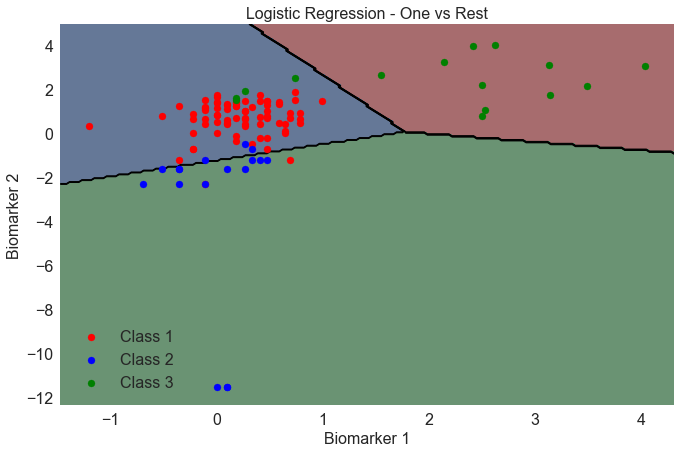

In [18]:
# Logistic Regression - One-vs-rest
logreg_ovr.fit(data_train.iloc[:,:-1],data_train.iloc[:,-1])

print('Logistic Regression One-vs-Rest: accuracy on train={:.2%}, test={:.2%}'.format(
    logreg_ovr.score(X_train, y_train), logreg_ovr.score(X_test, y_test)))

fig, ax = plt.subplots(1, 1, figsize=(11,7))

scatter_plot(
    ax, data_train,
    cls='Diagnosis',
    columns=['Biomarker 1', 'Biomarker 2'],
    class_labels=[1, 2, 3],
    class_colors=['r', 'b', 'g'], 
    title='Logistic Regression - One vs Rest', 
    fontsize=16)

overlay_decision_boundary(ax, logreg_ovr, desaturate=0.5)

Logistic Regression Multinomial: accuracy on train=91.59%, test=84.26%


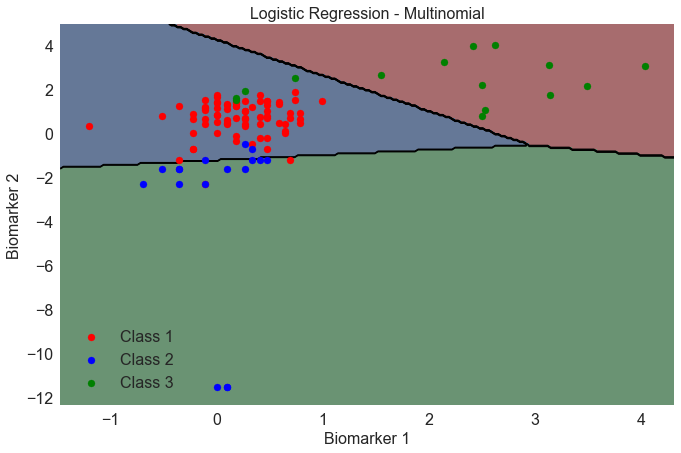

In [19]:
# Logistic Regression - Multinomial
logreg_mn.fit(data_train.iloc[:,:-1],data_train.iloc[:,-1])

print('Logistic Regression Multinomial: accuracy on train={:.2%}, test={:.2%}'.format(
    logreg_mn.score(X_train, y_train), logreg_mn.score(X_test, y_test)))

fig, ax = plt.subplots(1, 1, figsize=(11,7))

scatter_plot(
    ax, data_train,
    cls='Diagnosis',
    columns=['Biomarker 1', 'Biomarker 2'],
    class_labels=[1, 2, 3],
    class_colors=['r', 'b', 'g'], 
    title='Logistic Regression - Multinomial', 
    fontsize=16)

overlay_decision_boundary(ax, logreg_mn, desaturate=.5)

Polynomial Logistic Regression One-vs-Rest: accuracy on train=93.46%, test=86.11%


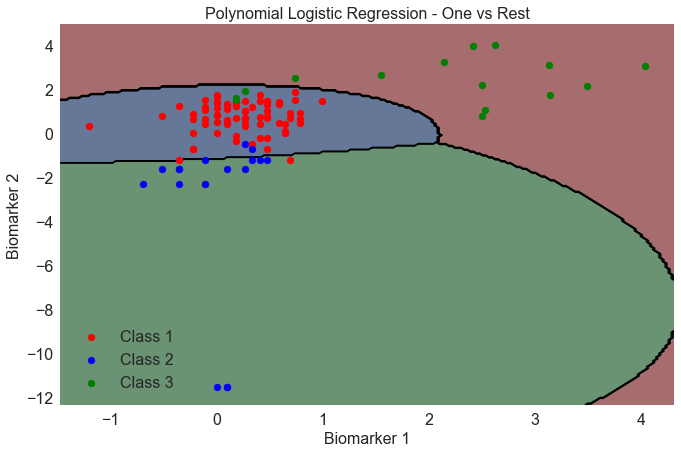

In [20]:
# Polynomial Logistic Regression - One-vs-rest
logreg_poly_ovr.fit(data_train.iloc[:,:-1],data_train.iloc[:,-1])

print('Polynomial Logistic Regression One-vs-Rest: accuracy on train={:.2%}, test={:.2%}'.format(
    logreg_poly_ovr.score(X_train, y_train), logreg_poly_ovr.score(X_test, y_test)))

fig, ax = plt.subplots(1, 1, figsize=(11,7))

scatter_plot(
    ax, data_train,
    cls='Diagnosis',
    columns=['Biomarker 1', 'Biomarker 2'],
    class_labels=[1, 2, 3],
    class_colors=['r', 'b', 'g'], 
    title='Polynomial Logistic Regression - One vs Rest', 
    fontsize=16)

overlay_decision_boundary(ax, logreg_poly_ovr, desaturate=0.5)

Polynomial Logistic Regression Multinomial: accuracy on train=93.46%, test=86.11%


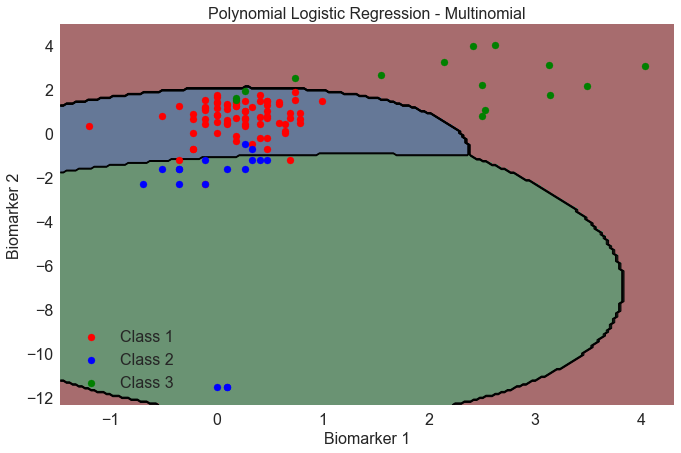

In [21]:
# Polynomial Logistic Regression - Multinomial
logreg_poly_mn.fit(data_train.iloc[:,:-1],data_train.iloc[:,-1])

print('Polynomial Logistic Regression Multinomial: accuracy on train={:.2%}, test={:.2%}'.format(
    logreg_poly_ovr.score(X_train, y_train), logreg_poly_ovr.score(X_test, y_test)))

fig, ax = plt.subplots(1, 1, figsize=(11,7))

scatter_plot(
    ax, data_train,
    cls='Diagnosis',
    columns=['Biomarker 1', 'Biomarker 2'],
    class_labels=[1, 2, 3],
    class_colors=['r', 'b', 'g'], 
    title='Polynomial Logistic Regression - Multinomial', 
    fontsize=16)

overlay_decision_boundary(ax, logreg_poly_mn, desaturate=0.5)

**2.2** Interpret the decision boundaries:
- Do these decision boundaries make sense?
- What does adding quadratic and interaction features do to the shape of the decision boundaries? Why?
- How do the different models treat regions where there are few samples? How do they classify such samples?


**Your answer here**

Interpret the decision boundaries:
- Q: Do these decision boundaries make sense?
- A: Yes, all the decision boundaries make sense in both models with and without polynomial and interaction terms. <br><br>

- Q: What does adding quadratic and interaction features do to the shape of the decision boundaries? Why?
- A: The decision boundaries become non-linear, because we are addding quadratic and interaction features to the logistic regression model.  <br><br>
- Q: How do the different models treat regions where there are few samples? How do they classify such samples?
- A: The logistic regression model without polynomial nor interaction terms (1st model) is trying to draw three straight lines to the seperate out the three classes. The logistic regression model with polynomial and interaction terms (2nd model) is trying to to draw three ellipses to isolate the three classes. The second model did a better job in seperating out the classes with few samples (class 2 and class 3), by drawing the quadratic decision boundaries to seprate the points on the boundaries more successfully. 

**2.3** Compare the performance of the two logistic regression models above using 5-fold cross-validation. Which model performs best? How confident are you about this conclusion? Does the inclusion of the polynomial terms in logistic regression yield better accuracy compared to the model with only linear terms? Why do you suspect it is better or worse?

*Hint*: You may use the `cross_val_score` function for cross-validation.

In [22]:
print('Logistic Regression One-vs-Rest: accuracy on train={:.2%}, test={:.2%}'.format(
    logreg_ovr.score(X_train, y_train), logreg_ovr.score(X_test, y_test)))
print('Logistic Regression Multinomial: accuracy on train={:.2%}, test={:.2%}'.format(
    logreg_mn.score(X_train, y_train), logreg_mn.score(X_test, y_test)))
print('Polynomial Logistic Regression One-vs-Rest: accuracy on train={:.2%}, test={:.2%}'.format(
    logreg_poly_ovr.score(X_train, y_train), logreg_poly_ovr.score(X_test, y_test)))
print('Polynomial Logistic Regression Multinomial: accuracy on train={:.2%}, test={:.2%}'.format(
    logreg_poly_ovr.score(X_train, y_train), logreg_poly_ovr.score(X_test, y_test)))

Logistic Regression One-vs-Rest: accuracy on train=91.59%, test=84.26%
Logistic Regression Multinomial: accuracy on train=91.59%, test=84.26%
Polynomial Logistic Regression One-vs-Rest: accuracy on train=93.46%, test=86.11%
Polynomial Logistic Regression Multinomial: accuracy on train=93.46%, test=86.11%


**Your answer here**

- The model with polynomial and interaction terms (second model) is performing better in both training and test sets.
- I'm very confident that second model is going to perform better on the training set, since it adds more features to make the model more flexible. I'm also confident that the second model is going to perform better on the test set, since it doesn't seem like linear boundaries could seperate out the three classes better than quadratic boundaries, but there may be some overfiting.  
- Yes, the model with polynomial and interaction terms (second model) is performing better in both training and test sets.
- I would suspect it to be better, with reasons listed on the 2nd bullet point.

<div class='exercise'><b> Question 3 [20 pts]: Discriminant Analysis</b></div>

**3.1** Consider the following synthetic dataset with two classes. A green star marks a test observation; which class do you think it belongs to? How would LDA classify that observation? How would QDA? Explain your reasoning.

**3.2** Now let's return to the thyroid dataset. Make a table of the total variance of each class for each biomarker.

**3.3** Fit LDA and QDA on the thyroid data, and plot the decision boundaries. Comment on how the decision boundaries differ. How does the difference in decision boundaries relate to characteristics of the data, such as the table you computed above?

**3.1** Consider the following synthetic dataset with two classes. A green star marks a test observation; which class do you think it belongs to? How would LDA classify that observation? How would QDA? Explain your reasoning.


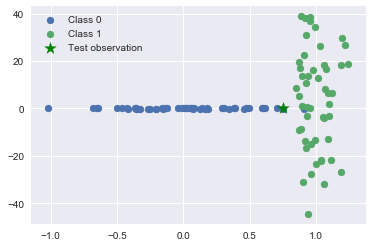

In [23]:
X_blobs, y_blobs = make_blobs(centers=[[0., 0.], [1., 0.]], cluster_std=[[.4, .1], [.1, 20.]], random_state=0)
plt.scatter(X_blobs[y_blobs==0][:,0], X_blobs[y_blobs==0][:,1], label="Class 0")
plt.scatter(X_blobs[y_blobs==1][:,0], X_blobs[y_blobs==1][:,1], label="Class 1")
plt.scatter([.75], [0.], color="green", marker="*", s=150, label="Test observation")
plt.legend();

In [24]:
# Data pre-processing
df_blobs = pd.DataFrame(X_blobs, y_blobs)
df_blobs.reset_index(inplace=True)
df_blobs.rename({0: 'x1', 1: 'x2', 'index': 'class'}, axis=1, inplace=True)
df_blobs = df_blobs[['x1', 'x2', 'class']]
display(df_blobs.head())
print(df_blobs.shape)

,x1,x2,class
0,0.061979,0.037816,0
1,0.935638,-44.468063,1
2,0.026607,0.030247,0
3,0.889562,1.043302,1
4,0.954447,0.349583,1


(100, 3)


LDA for blobs: accuracy on train=94.00%


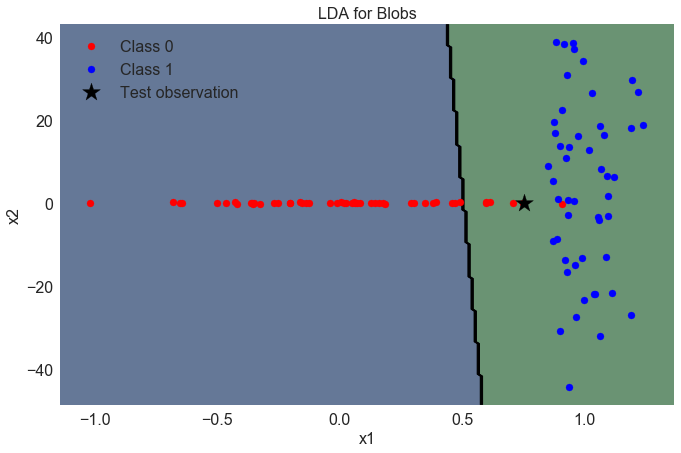

In [25]:
# LDA for blobs
lda_blobs = LinearDiscriminantAnalysis()
lda_blobs.fit(df_blobs.iloc[:,:-1], df_blobs.iloc[:,-1])

print('LDA for blobs: accuracy on train={:.2%}'.format(lda_blobs.score(df_blobs.iloc[:,:-1], df_blobs.iloc[:,-1])))

fig, ax = plt.subplots(1, 1, figsize=(11,7))

scatter_plot(
    ax, df_blobs,
    cls='class',
    columns=['x1', 'x2'],
    class_labels=[0, 1],
    class_colors=['r', 'b'], 
    title='LDA for Blobs', 
    fontsize=16)

ax.scatter([.75], [0.], color="black", marker="*", s=350, label="Test observation")
ax.legend(fontsize=16)

overlay_decision_boundary(ax, lda_blobs, desaturate=0.5)

QDA for blobs: accuracy on train=100.00%


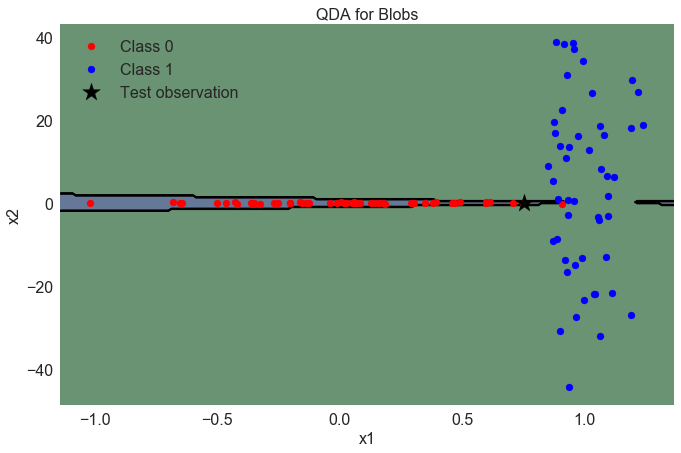

In [26]:
# QDA for blobs
qda_blobs = QuadraticDiscriminantAnalysis()
qda_blobs.fit(df_blobs.iloc[:,:-1], df_blobs.iloc[:,-1])

print('QDA for blobs: accuracy on train={:.2%}'.format(qda_blobs.score(df_blobs.iloc[:,:-1], df_blobs.iloc[:,-1])))

fig, ax = plt.subplots(1, 1, figsize=(11,7))

scatter_plot(
    ax, df_blobs,
    cls='class',
    columns=['x1', 'x2'],
    class_labels=[0, 1],
    class_colors=['r', 'b'], 
    title='QDA for Blobs', 
    fontsize=16)

ax.scatter([.75], [0.], color="black", marker="*", s=350, label="Test observation")
ax.legend(fontsize=16)

overlay_decision_boundary(ax, qda_blobs, desaturate=0.5)

In [27]:
# Total variance of each class for each predictor
df_blobs.groupby('class')[['x1', 'x2']].var()

,x1,x2
class,,
0,0.173098,0.009875
1,0.010489,446.057155


**Your answer here**

The classification of the test observation would depend on the classifiers: 
- LDA: would classify the test observation as class 1 as shown in the above chart. LDA is not right model for this classfication problem, because the variances of each class for each predictor are very different as shown in the above table, which violates the assumption of LDA model.
- QDA: would classify the test observation as class 0 as shown in the above chart. QDA is better than LDA for this dataset, since the covariances are not constant. 

**3.2** Now let's return to the thyroid dataset. Make a table of the total variance of each class for each biomarker.


In [28]:
# Total variance of each class for each predictor
data_train.groupby('Diagnosis')[['Biomarker 1', 'Biomarker 2']].var()

,Biomarker 1,Biomarker 2
Diagnosis,,
1,0.134103,0.607021
2,0.120058,15.734945
3,1.537893,0.963413


**3.3** Fit LDA and QDA on the thyroid data, and plot the decision boundaries. Comment on how the decision boundaries differ. How does the difference in decision boundaries relate to characteristics of the data, such as the table you computed above?

LDA: accuracy on train=85.05%, test=81.48%


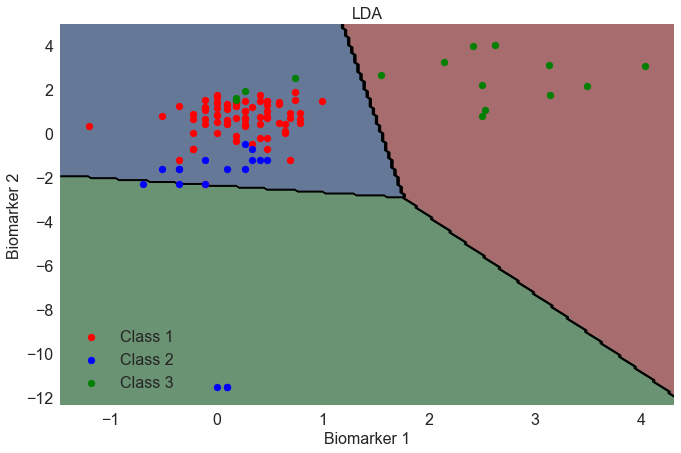

In [29]:
# LDA
lda = LinearDiscriminantAnalysis()
lda.fit(data_train.iloc[:,:-1],data_train.iloc[:,-1])

print('LDA: accuracy on train={:.2%}, test={:.2%}'.format(
    lda.score(X_train, y_train), lda.score(X_test, y_test)))

fig, ax = plt.subplots(1, 1, figsize=(11,7))

scatter_plot(
    ax, data_train,
    cls='Diagnosis',
    columns=['Biomarker 1', 'Biomarker 2'],
    class_labels=[1, 2, 3],
    class_colors=['r', 'b', 'g'], 
    title='LDA', 
    fontsize=16)

overlay_decision_boundary(ax, lda, desaturate=0.5)

QDA: accuracy on train=87.85%, test=85.19%


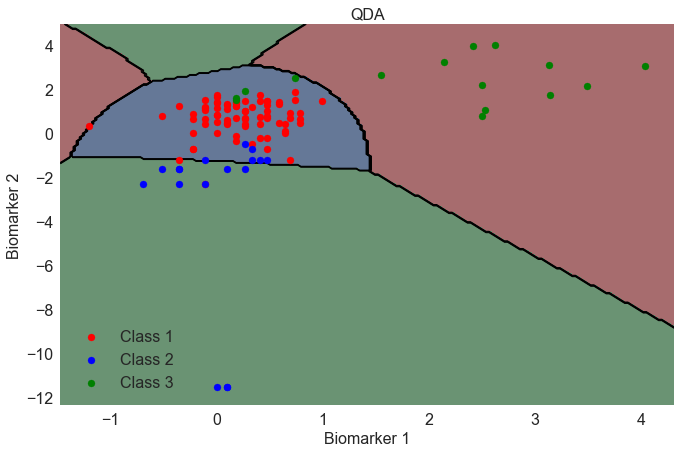

In [30]:
# QDA
qda = QuadraticDiscriminantAnalysis()
qda.fit(data_train.iloc[:,:-1],data_train.iloc[:,-1])

print('QDA: accuracy on train={:.2%}, test={:.2%}'.format(
    qda.score(X_train, y_train), qda.score(X_test, y_test)))

fig, ax = plt.subplots(1, 1, figsize=(11,7))

scatter_plot(
    ax, data_train,
    cls='Diagnosis',
    columns=['Biomarker 1', 'Biomarker 2'],
    class_labels=[1, 2, 3],
    class_colors=['r', 'b', 'g'], 
    title='QDA', 
    fontsize=16)

overlay_decision_boundary(ax, qda, desaturate=0.5)

**Your answer here**

- LDA vs QDA: 
    - LDA: Decision boundaries are linear. LDA assumes multivariate normality and homogeneity of variance/covariance 
    - QDA: Decision boundaries are quadratic. QDA differs from LDA that covariances of the MVN distributions within classes can be different.  
    
- QDA decision boundaries vs total variance table: 
    - For class 1, variance for biomarker 1 and biomarker 2 are comparable, and both are small. 
    - For class 2, variance for biomarker 2 is larger than that of biomarker 1.
    - For class 3, variance for biomarker 1 is larger than that of biomarker 2.
    - The larger the variance, the larger the area of of each class in the above chart. 

<div class='exercise'> <b> Question 4 [20 pts]: Fit Decision Trees </b> </div> 


We next try out decision trees for thyroid classification. For the following questions, you should use the *Gini* index as the splitting criterion while fitting the decision tree. 

*Hint:* You should use the `DecisionTreeClassifier` class to fit a decision tree classifier and the `max_depth` attribute to set the tree depth.

**4.1**. Fit a decision tree model to the thyroid data set with (maximum) tree depths 2, 3, ..., 10. Make plots of the accuracy as a function of the maximum tree depth, on the training set and the mean score on the validation sets for 5-fold CV. Is there a depth at which the fitted decision tree model achieves near-perfect classification on the training set? If so, what can you say about how this tree will generalize? Which hyperparameter setting gives the best cross-validation performance?

**4.2**: Visualize the decision boundaries of the best decision tree you just fit. How are the shapes of the decision boundaries for this model different from the other methods we have seen so far? Given an explanation for your observation.

**4.3** Explain *in words* how the best fitted model diagnoses 'hypothyroidism' for a new patient. You can use the code below to examine the structure of the best decision tree.

**4.1**. Fit a decision tree model to the thyroid data set with (maximum) tree depths 2, 3, ..., 10. Make plots of the accuracy as a function of the maximum tree depth, on the training set and the mean score on the validation sets for 5-fold CV. Is there a depth at which the fitted decision tree model achieves near-perfect classification on the training set? If so, what can you say about how this tree will generalize? Which hyperparameter setting gives the best cross-validation performance?


In [31]:
train_scores = []
validation_scores = []
test_scores = []

depths = [i for i in range(2, 11)]

for depth in depths:
    tree_model = DecisionTreeClassifier(max_depth = depth)

    tree_model.fit(data_train.iloc[:,:-1], data_train.iloc[:,-1])
    train_scores.append(tree_model.score(data_train.iloc[:,:-1],data_train.iloc[:,-1]))
    test_scores.append(tree_model.score(data_test.iloc[:,:-1],data_test.iloc[:,-1]))
    
    val_score = cross_val_score(estimator=tree_model, X=data_train.iloc[:,:-1], y=data_train.iloc[:,-1], cv=5)
    validation_scores.append(np.mean(val_score))

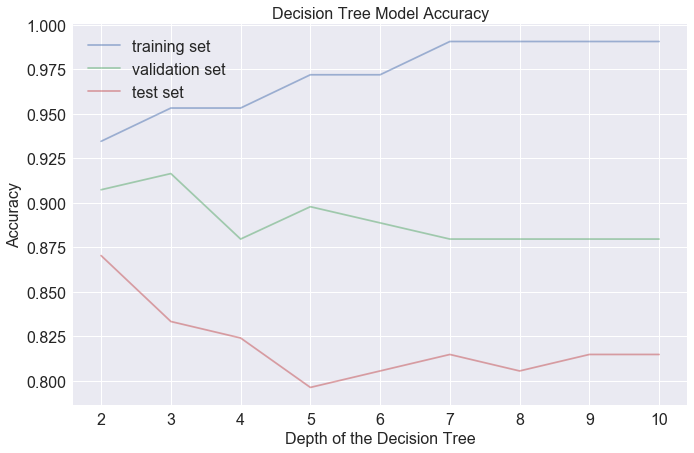

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(11, 7))
ax.plot(depths, train_scores, alpha=0.5, label='training set')  
ax.plot(depths, validation_scores, alpha=0.5, label='validation set')  
ax.plot(depths, test_scores, alpha=0.5, label='test set')  
ax.tick_params(labelsize=16)
ax.set_title('Decision Tree Model Accuracy', fontsize=16)
ax.set_xlabel('Depth of the Decision Tree', fontsize=16)
ax.set_ylabel('Accuracy', fontsize=16)
ax.legend(fontsize=16)
plt.show()

In [33]:
scores = pd.DataFrame({'train_set': train_scores, 
                       'validation_set': validation_scores, 
                       'test_scores': test_scores, 
                       'depth': range(2, 11)})
scores.set_index('depth')

,train_set,validation_set,test_scores
depth,,,
2,0.934579,0.907359,0.870370
3,0.953271,0.916450,0.833333
4,0.953271,0.879654,0.824074
5,0.971963,0.897835,0.796296
6,0.971963,0.888745,0.805556
7,0.990654,0.879654,0.814815
8,0.990654,0.879654,0.805556
9,0.990654,0.879654,0.814815
10,0.990654,0.879654,0.814815


**Your answer here**

- Q: Is there a depth at which the fitted decision tree model achieves near-perfect classification on the training set? 
- A: At depth of 7, the fitted decision tree model achieves near-perfect classification on the training set. <br><br>

- Q: If so, what can you say about how this tree will generalize? 
- A: The tree is definitely overfitted at depth 7. <br><br>

- Q: Which hyperparameter setting gives the best cross-validation performance?
- A: Depth of 3 gives the highest cross-validation accuracy.

**4.2**: Visualize the decision boundaries of the best decision tree you just fit. How are the shapes of the decision boundaries for this model different from the other methods we have seen so far? Given an explanation for your observation.

Decision Tree: accuracy on train=95.33%, test=83.33%


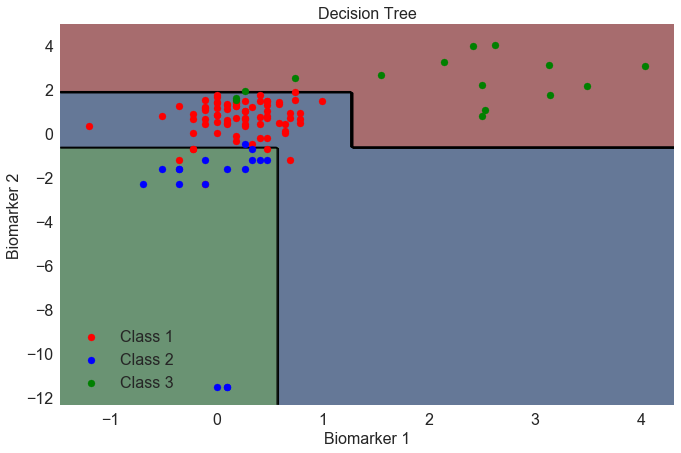

In [34]:
# Decision Tree
depth = 3
tree_model = DecisionTreeClassifier(max_depth = depth)
tree_model.fit(data_train.iloc[:,:-1], data_train.iloc[:,-1])

print('Decision Tree: accuracy on train={:.2%}, test={:.2%}'.format(
    tree_model.score(X_train, y_train), tree_model.score(X_test, y_test)))

fig, ax = plt.subplots(1, 1, figsize=(11,7))

scatter_plot(
    ax, data_train,
    cls='Diagnosis',
    columns=['Biomarker 1', 'Biomarker 2'],
    class_labels=[1, 2, 3],
    class_colors=['r', 'b', 'g'], 
    title='Decision Tree', 
    fontsize=16)

overlay_decision_boundary(ax, tree_model, desaturate=0.5)

**Your answer here**

- Q: How are the shapes of the decision boundaries for this model different from the other methods we have seen so far? 
- A: 
    - Decision Tree: boundaries are all horizontal and vertical lines. 
    - LDA & logistic without polynomial terms: boundaries are lines not resticted to horizontal or vertical.
    - QDA & logistic with polynomial terms: boundaries are quadratic.
<br><br>
- Q: Given an explanation for your observation.
- A: In decision tree models, each node is spliting observations into two groups by comparing one feature value to a threshold, which are the corresponding horizontal and vertical lines in the above chart in two features space.

**4.3** Explain *in words* how the best fitted model diagnoses 'hypothyroidism' for a new patient. You can use the code below to examine the structure of the best decision tree.

*Entirely optional note:* You can also generate a visual representation using the `export_graphviz`. However, viewing the generated GraphViz file requires additional steps. One approach is to paste the generated graphviz file in the text box at http://www.webgraphviz.com/. Alternatively, you can run GraphViz on your own computer, but you may need to install some additional software. Refer to the [Decision Tree section of the sklearn user guide](http://scikit-learn.org/stable/modules/tree.html#classification) for more information.

In [35]:
# This code is adapted from
# http://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
def show_tree_structure(clf):
    tree = clf.tree_

    n_nodes = tree.node_count
    children_left = tree.children_left
    children_right = tree.children_right
    feature = tree.feature
    threshold = tree.threshold

    # The tree structure can be traversed to compute various properties such
    # as the depth of each node and whether or not it is a leaf.
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

    print(f"The binary tree structure has {n_nodes} nodes:\n")
    
    for i in range(n_nodes):
        indent = node_depth[i] * "  "
        if is_leaves[i]:
            prediction = clf.classes_[np.argmax(tree.value[i])]
            print(f"{indent}node {i}: predict class {prediction}")
        else:
            print("{}node {}: if X[:, {}] <= {:.3f} then go to node {}, else go to node {}".format(
                indent, i, feature[i], threshold[i], children_left[i], children_right[i]))

In [36]:
show_tree_structure(tree_model)

The binary tree structure has 11 nodes:

node 0: if X[:, 1] <= -0.693 then go to node 1, else go to node 6
  node 1: if X[:, 0] <= 0.582 then go to node 2, else go to node 5
    node 2: if X[:, 0] <= -0.053 then go to node 3, else go to node 4
      node 3: predict class 2
      node 4: predict class 2
    node 5: predict class 1
  node 6: if X[:, 0] <= 1.270 then go to node 7, else go to node 10
    node 7: if X[:, 1] <= 1.879 then go to node 8, else go to node 9
      node 8: predict class 1
      node 9: predict class 3
    node 10: predict class 3


In [37]:
export_graphviz(tree_model, out_file='tree_model.dot')

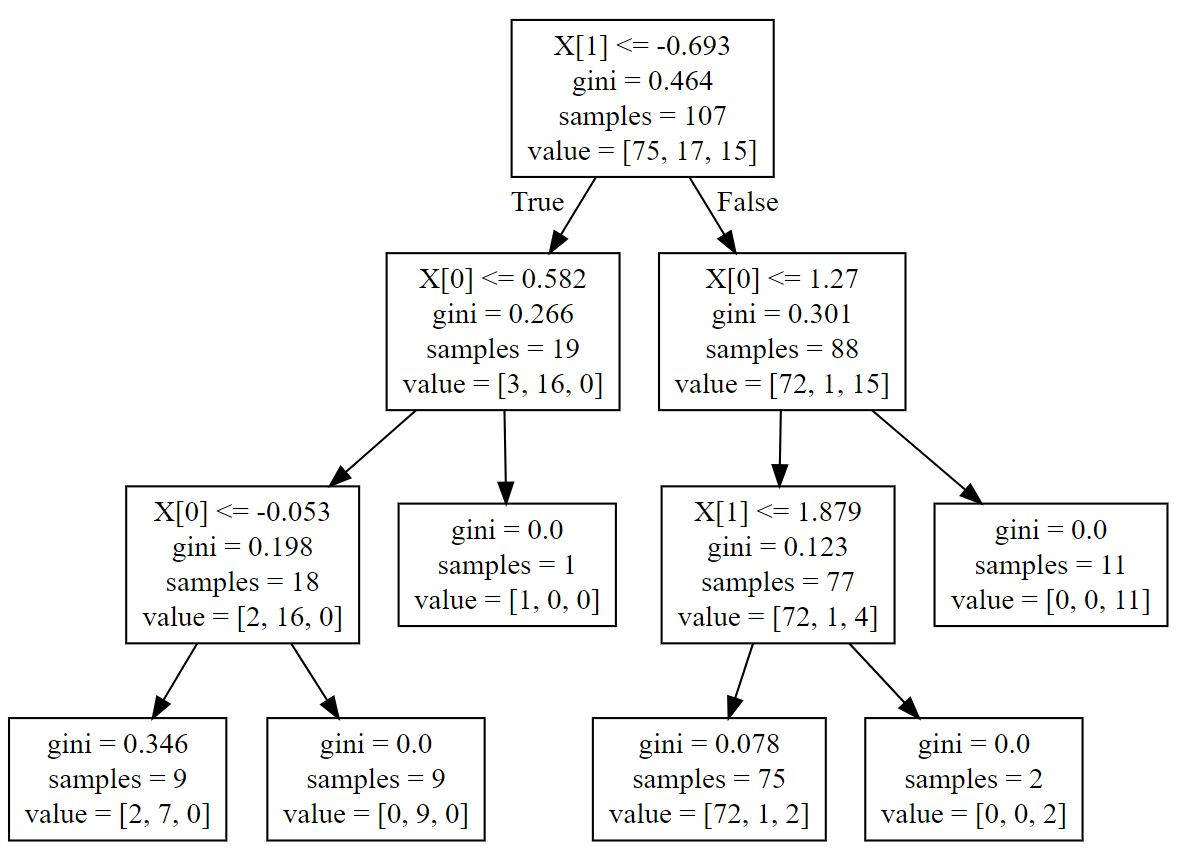

In [38]:
Image('tree_model.jpg')

**Your answer here**

Steps to diagnoses 'hypothyroidism' for a new patient: 
- If biomarker 2 is less or equal to -0.693: 
    - If and biomarker 1 is less or equal to 1.27: 
        - If biomarker 2 is larger than 1.879: 
            - The patient haves 'hypothyroidism'.
    - Else, The patient haves 'hypothyroidism'.

<div class='exercise'><b> Question 5 [18 pts]: k-NN and Model comparison </b> </div>

We have now seen six different ways of fitting a classification model: **linear logistic regression**, **logistic regression with polynomial terms**, **LDA**, **QDA**, **decision trees**, and in this problem we'll add **k-NN**. Which of these methods should we use in practice for this problem? To answer this question, we now compare and contrast these methods.

**5.1** Fit a k-NN classifier with uniform weighting to the training set. Use 5-fold CV to pick the best $k$.

*Hint: Use `KNeighborsClassifier` and `cross_val_score`.*

**5.2** Plot the decision boundaries for each of the following models that you fit above. For models with hyperparameters, use the values you chose using cross-validation.
- Logistic Regression (linear)
- Logistic Regression (polynomial)
- Linear Discriminant Analysis 
- Quadratic Discriminant Analysis
- Decision Tree
- k-NN

Comment on the difference in the decision boundaries between the following pairs of models. Why does this difference make sense given how the model works?
- Linear logistic regression; LDA
- Quadratic logistic regression; QDA.
- k-NN and whichever other model has the most complex decision boundaries

**5.3** Describe how each model classifies an observation from the test set in one short sentence for each (assume that the model is already fit). For example, for the linear regression classifier you critiqued in hw5, you might write: "It classifies the observation as class 1 if the dot product of the feature vector with the the model coefficients (with constant added) exceeds 0.5."

- Logistic Regression (One-vs-Rest)
- Linear Discriminant Analysis
- Quadratic Discriminant Analysis
- k-Nearest-Neighbors Classifier
- Decision Tree

**5.4** Estimate the validation accuracy for each of the models. Summarize your results in a graph or table. (Note: for some models you have already run these computations; it's ok to redo them here if it makes your code cleaner.)

**5.5** Based on everything you've found in this question so far, which model would you expect to perform best on our test data? 

Now evaluate each fitted model's performance on the test set. Also, plot the same decision boundaries as above, but now showing the test set. How did the overall performance compare with your performance estimates above? Which model actually performed best? Why do you think this is the case?

**5.6**. Compare and contrast the six models based on each of the following criteria (a supporting table to summarize your  thoughts can be helpful):
  - Classification performance
  - Complexity of decision boundary
  - Memory storage
  - Interpretability

If you were a clinician who had to use the classifier to diagnose thyroid disorders in patients, which among the six methods would you be most comfortable in using? Justify your choice in terms of at least 3 different aspects.

**5.1** Fit a k-NN classifier with uniform weighting to the training set. Use 5-fold CV to pick the best $k$.

*Hint: Use `KNeighborsClassifier` and `cross_val_score`.*

Best k: 4
kNN: accuracy on train=92.52%, test=85.19%


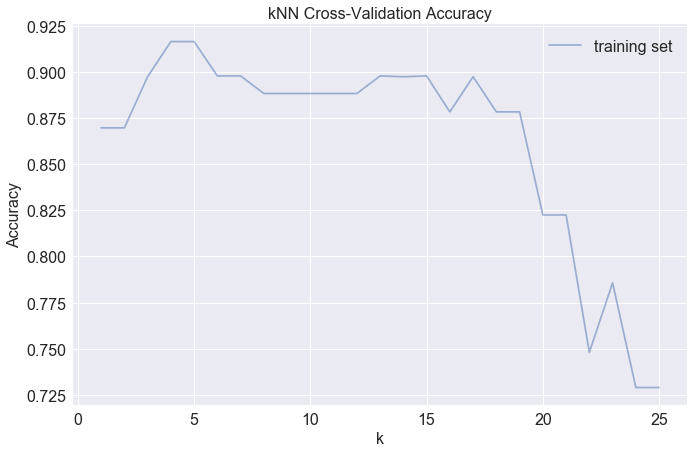

In [39]:
max_score = 0
max_k = 0 
scores = []

for k in range(1, 26):
    knn = KNeighborsClassifier(n_neighbors = k)
    score = cross_val_score(knn, data_train.iloc[:,:-1], data_train.iloc[:,-1], cv=5).mean()
    scores.append(score)
    if score > max_score:
        max_k = k
        max_score = score
        
scores = pd.DataFrame({'k': range(1, 26), 'accuracy': scores})

knn = KNeighborsClassifier(n_neighbors = max_k)
knn.fit(data_train.iloc[:,:-1],data_train.iloc[:,-1])

print('Best k: ' + str(max_k))
print('kNN: accuracy on train={:.2%}, test={:.2%}'.format(
    knn.score(X_train, y_train), knn.score(X_test, y_test)))

fig, ax = plt.subplots(1, 1, figsize=(11, 7))
ax.plot(scores['k'], scores['accuracy'], alpha=0.5, label='training set')  
ax.tick_params(labelsize=16)
ax.set_title('kNN Cross-Validation Accuracy', fontsize=16)
ax.set_xlabel('k', fontsize=16)
ax.set_ylabel('Accuracy', fontsize=16)
ax.legend(fontsize=16)
plt.show()

**5.2** Plot the decision boundaries for each of the following models that you fit above. For models with hyperparameters, use the values you chose using cross-validation.
- Logistic Regression (linear)
- Logistic Regression (polynomial)
- Linear Discriminant Analysis 
- Quadratic Discriminant Analysis
- Decision Tree
- k-NN

Comment on the difference in the decision boundaries between the following pairs of models. Why does this difference make sense given how the model works?
- Linear logistic regression; LDA
- Quadratic logistic regression; QDA.
- k-NN and whichever other model has the most complex decision boundaries


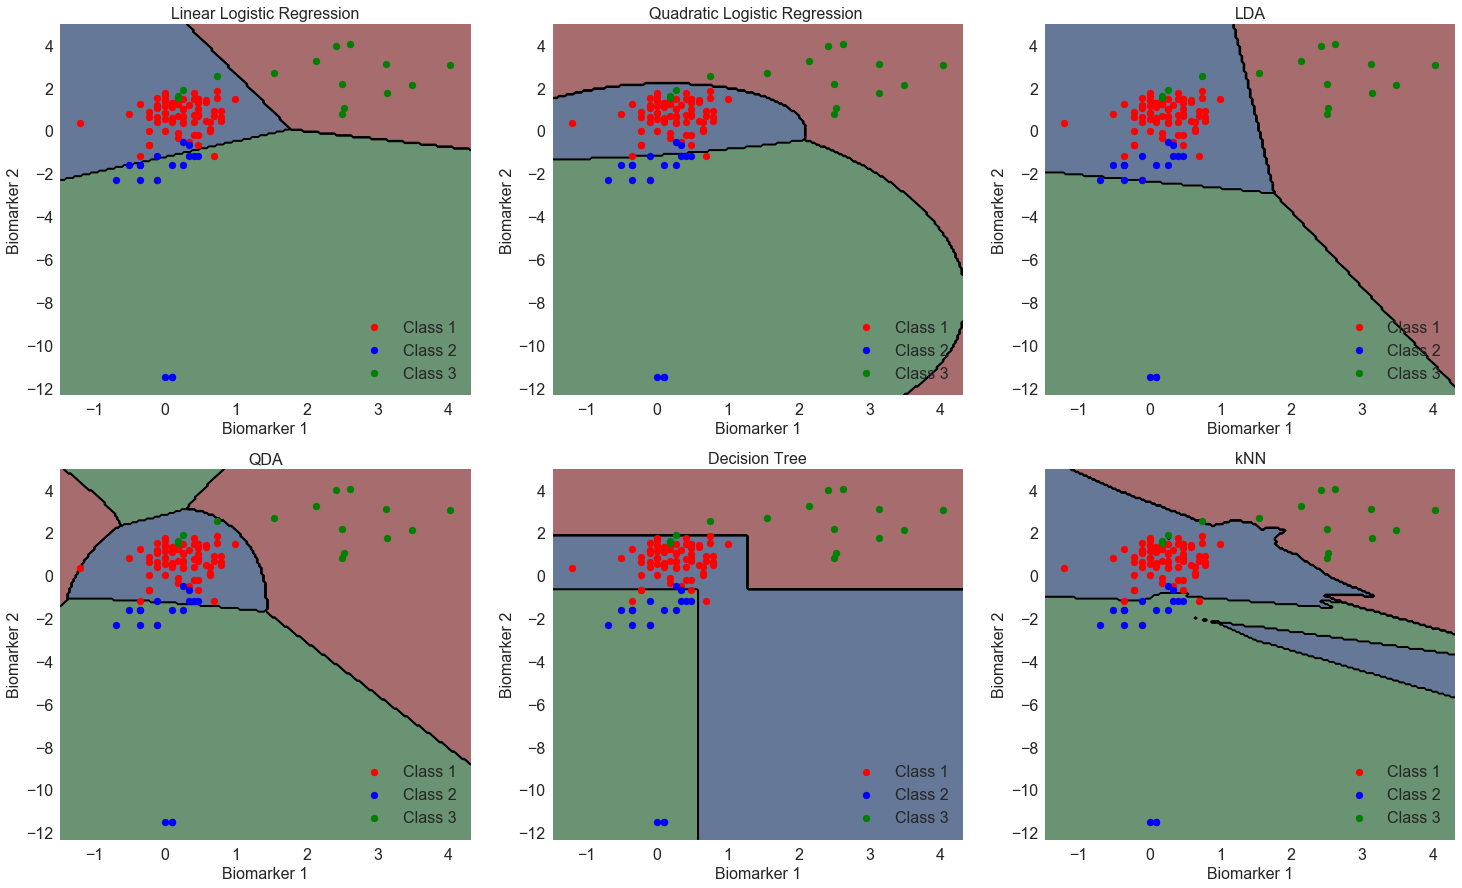

In [40]:
fitted_models = [logreg_ovr, logreg_poly_ovr, lda, qda, tree_model, knn]
titles = ['Linear Logistic Regression', 'Quadratic Logistic Regression ', 'LDA', 'QDA', 'Decision Tree', 'kNN']

f, axes = plt.subplots(2, 3, figsize = (25, 15))

for i in range(len(axes)):
    for j in range(len(axes[0])):
        mod = fitted_models[i * 3 + j]
               
        scatter_plot(
            axes[i,j], data_train,
            cls='Diagnosis',
            columns=['Biomarker 1', 'Biomarker 2'],
            class_labels=[1, 2, 3],
            class_colors=['r', 'b', 'g'], 
            title=titles[i * 3 + j], 
            fontsize=16
        )

        overlay_decision_boundary(axes[i,j], mod, desaturate=0.5)

**your answer here**


- Linear logistic regression vs LDA:
    - The boundaries of the two models are similar, of which are all straight lines.
    - LDA assumes multivariate normality and homogeneity of variance/covariance, and this explains why the area under each class are very similar under LDA, while logistic regression doesn't have this assumption. <br>
- Quadratic logistic regression vs QDA: 
    - The boundaries of the two models are similar, of which are all quadratic lines.
    - QDA is trying to draw three ellipses to seperate the three classes, with the area positively correlated to the variances of the predictors within each class. The variances of predictors within class 2 are smaller than the other two classes, and that's why the area of class 2 under QDA is the smallest. Logistic regression doens't have to draw ellipses to seperate the classes. <br>
- k-NN and QDA:  
    - k-NN boundaries are very complicated and non-linear, which are zigzaging to seperate the points to three classes. 
    - QDA boundaries are also complicated, but it's clear to see that the boundaries are quadratic, not like kNN's zigzaging boundaries. 



**5.3** Describe how each model classifies an observation from the test set in one short sentence for each (assume that the model is already fit). For example, for the linear regression classifier you critiqued in hw5, you might write: "It classifies the observation as class 1 if the dot product of the feature vector with the the model coefficients (with constant added) exceeds 0.5."

- Logistic Regression (One-vs-Rest)
- Linear Discriminant Analysis
- Quadratic Discriminant Analysis
- k-Nearest-Neighbors Classifier
- Decision Tree

**Your answer here**

- Logistic Regression (One-vs-Rest): 
    - It classifies the observation as the class with the largest estimated probability. 
- Linear Discriminant Analysis: 
    - It classifies the observation as the class with the largest estimated probability, assuming the multivariate normality and homogeneity of variance and covariance. 
- Quadratic Discriminant Analysis
    - It classifies the observation as the class with the largest estimated probability, assuming the multivariate normality and homogeneity of variance.  
- k-Nearest-Neighbors Classifier: 
    - It classifies the observation as the class with the highest frequencies wihtin its top k nearest neighbors.
- Decision Tree: 
    - It classifies the observation as the leaf class node in the decision flow chart.  

**5.4** Estimate the validation accuracy for each of the models. Summarize your results in a graph or table. (Note: for some models you have already run these computations; it's ok to redo them here if it makes your code cleaner.)

In [41]:
val_score = lambda x: cross_val_score(x, data_train.iloc[:,:-1], data_train.iloc[:,-1], cv=5).mean()

logreg_ovr_val = val_score(logreg_ovr)
logreg_poly_ovr_val = val_score(logreg_poly_ovr)
lda_val = val_score(lda)
qda_val = val_score(qda)
knn_val = val_score(knn)
tree_model_val = val_score(tree_model)

,validation score,index
0,0.916883,log_lin
1,0.906926,log_qdr
2,0.850649,lda
3,0.887879,qda
4,0.916450,knn
5,0.916450,tree


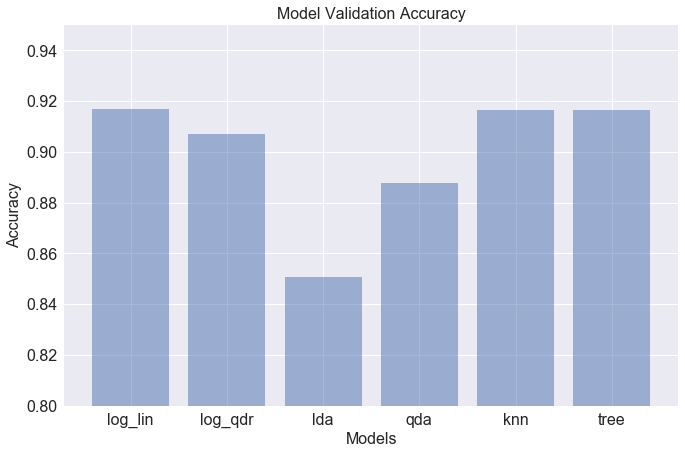

In [42]:
model_val_scores = pd.DataFrame({'validation score': [logreg_ovr_val, logreg_poly_ovr_val, 
                                                      lda_val, qda_val, knn_val, tree_model_val],
                                 'index': ['log_lin', 'log_qdr', 'lda', 'qda', 'knn', 'tree']})
model_val_scores.set_index('index')
display(model_val_scores)

fig, ax = plt.subplots(1, 1, figsize=(11, 7))
ax.bar(model_val_scores['index'], model_val_scores['validation score'], alpha=0.5)  
ax.tick_params(labelsize=16)
ax.set_ylim((0.80, 0.95))
ax.set_title('Model Validation Accuracy', fontsize=16)
ax.set_xlabel('Models', fontsize=16)
ax.set_ylabel('Accuracy', fontsize=16)
plt.show()

**Your answer here**

In terms of model validation accuracies: 
    - Linear logistic > Quadratic logistic > kNN = Decision Tree > QDA > LDA

**5.5** Based on everything you've found in this question so far, which model would you expect to perform best on our test data? 

Now evaluate each fitted model's performance on the test set. Also, plot the same decision boundaries as above, but now showing the test set. How did the overall performance compare with your performance estimates above? Which model actually performed best? Why do you think this is the case?

,test score,index
0,0.842593,log_lin
1,0.861111,log_qdr
2,0.814815,lda
3,0.851852,qda
4,0.851852,knn
5,0.833333,tree


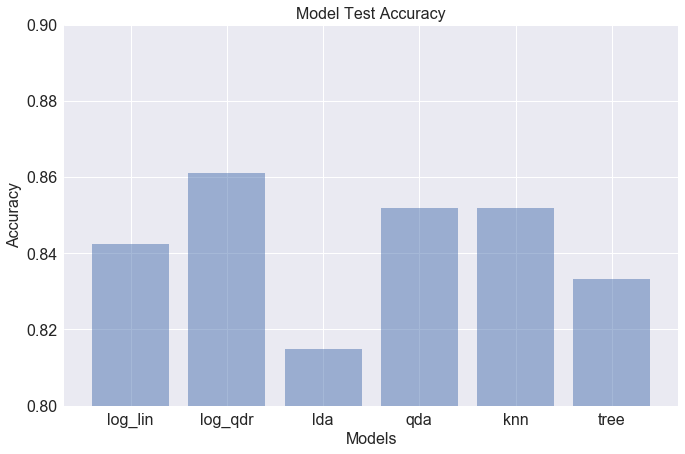

In [43]:
logreg_ovr_tst = logreg_ovr.score(X_test, y_test)
logreg_poly_ovr_tst = logreg_poly_ovr.score(X_test, y_test)
lda_tst = lda.score(X_test, y_test)
qda_tst = qda.score(X_test, y_test)
knn_tst = knn.score(X_test, y_test)
tree_model_tst = tree_model.score(X_test, y_test)

model_tst_scores = pd.DataFrame({'test score': [logreg_ovr_tst, logreg_poly_ovr_tst, 
                                                lda_tst, qda_tst, knn_tst, tree_model_tst],
                 
                                 
                                 'index': ['log_lin', 'log_qdr', 'lda', 'qda', 'knn', 'tree']})
model_tst_scores.set_index('index')
display(model_tst_scores)

fig, ax = plt.subplots(1, 1, figsize=(11, 7))
ax.bar(model_tst_scores['index'], model_tst_scores['test score'], alpha=0.5)  
ax.tick_params(labelsize=16)
ax.set_ylim((0.80, 0.90))
ax.set_title('Model Test Accuracy', fontsize=16)
ax.set_xlabel('Models', fontsize=16)
ax.set_ylabel('Accuracy', fontsize=16)
plt.show()

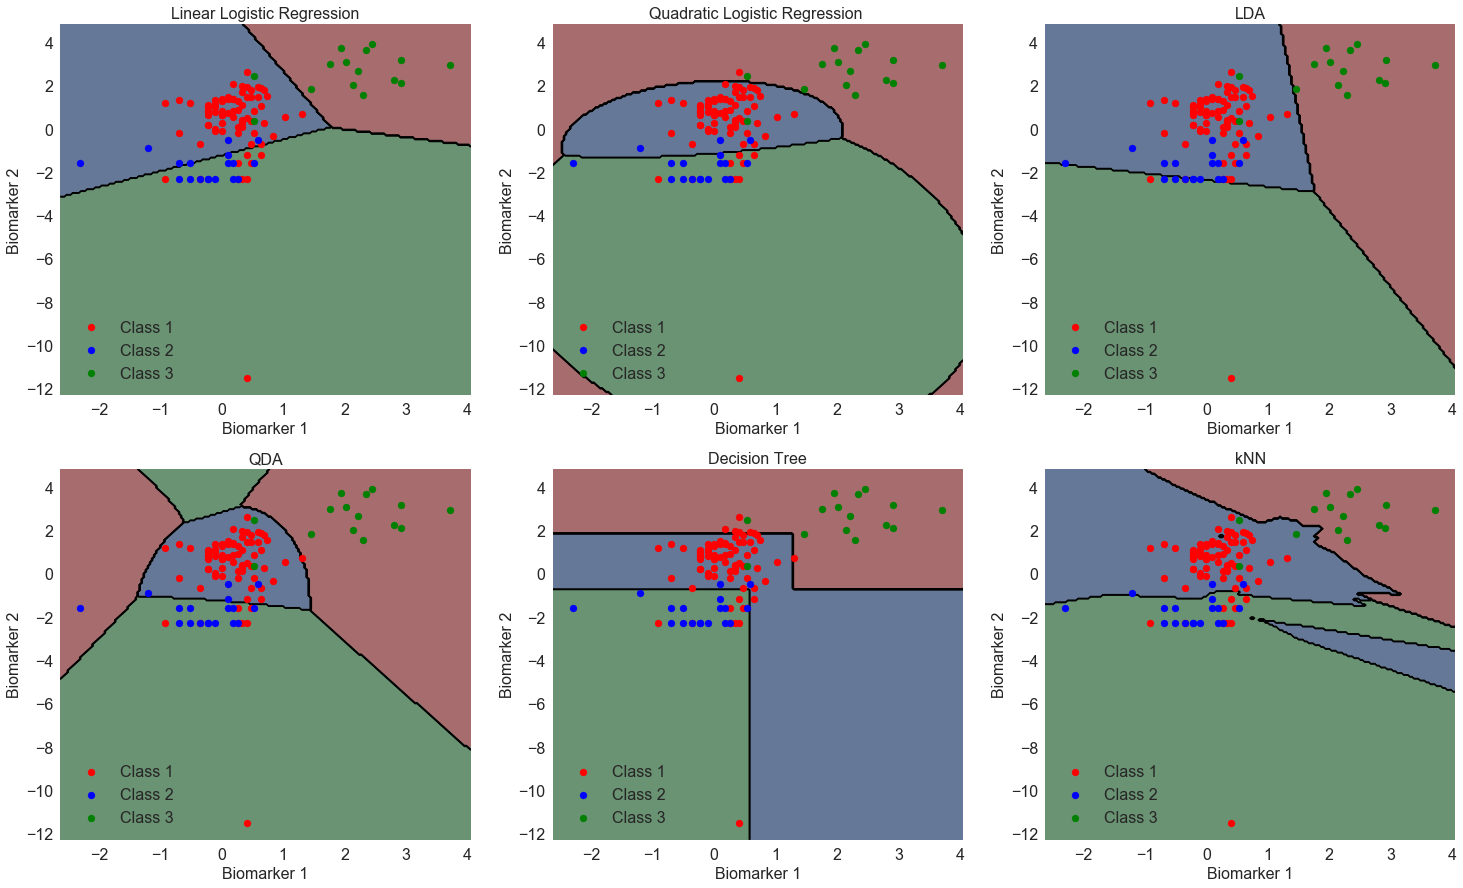

In [44]:
fitted_models = [logreg_ovr, logreg_poly_ovr, lda, qda, tree_model, knn]
titles = ['Linear Logistic Regression', 'Quadratic Logistic Regression ', 'LDA', 'QDA', 'Decision Tree', 'kNN']

f, axes = plt.subplots(2, 3, figsize = (25, 15))

for i in range(len(axes)):
    for j in range(len(axes[0])):
        mod = fitted_models[i * 3 + j]
               
        scatter_plot(
            axes[i,j], data_test,
            cls='Diagnosis',
            columns=['Biomarker 1', 'Biomarker 2'],
            class_labels=[1, 2, 3],
            class_colors=['r', 'b', 'g'], 
            title=titles[i * 3 + j], 
            fontsize=16
        )

        overlay_decision_boundary(axes[i,j], mod, desaturate=0.5)

**your answer here**

- Q: How did the overall performance compare with your performance estimates above? 
- A: In terms of model validation accuracies, Linear logistic > Quadratic logistic > kNN = Decision Tree > QDA > LDA. In terms of model test accuracies, Quadratic logistic > QDA = kNN > Linear logistic > Decision Tree > LDA. In general, the validation accruracy ranking is similar to the test accuracy ranking among models. Linear/Quadratic Logistic regression models performs the best, and LDA performs the worst. 
<br><br>

- Q: Which model actually performed best? 
- A: Quadratic logistic regression perfomred the best in test set.<br><br>

- Q: Why do you think this is the case?
- A: Some of the classes overlap with each other, so it's not possible to use linear boundaries to seperate the classes well, which means Linear Logistic Regression, LDA and Decision Tree models will not be the best one. kNN seems to overfit the training set, such that the boundaries are zigzaging amongh the points. QDA assumes multivariate normal distribution, which doesn't seem to be satisfied well in the training set either. So I would have expected quadratic logistic regression to perform the best in the test set. <br><br>


**5.6**. Compare and contrast the six models based on each of the following criteria (a supporting table to summarize your  thoughts can be helpful):
  - Classification performance
  - Complexity of decision boundary
  - Memory storage
  - Interpretability

If you were a clinician who had to use the classifier to diagnose thyroid disorders in patients, which among the six methods would you be most comfortable in using? Justify your choice in terms of at least 3 different aspects.

**your answer here**

The below table is comparing the six models on a relative basis. <br>


||Classification performance|Complexity of decision boundary|Memory storage|Interpretability|
|------|------|------|------|------|
|Linear Logistic Regression | Medium | Simple | Medium | High | 
|Quadratic Logistic Regression | Good | Medium | Medium | High | 
|LDA  | Bad | Simple | Low | Low |
|QDA  | Good | Medium | Low | Low |
|kNN  | Medium | Complex | High | Midum |
|Decision Tree  | Bad | Simple | High | High |



  - Classification performance: 
      - Based on the classification performance on the test set, quadratic logistic regression and QDA performed the best, while decision tree and LDA performed the worsest. 
  - Complexity of decision boundary: 
      - Linear logistic regression, LDA and decistion tree models all have simple decision boundaries with straight lines, while kNN has highly non-linear complex boundaries. 
  - Memory storage: 
      - LDA and QDA don't need to go through iterative process to estimate coefficients, so the memory storage is low. kNN is suffering from the curse of dimensionality, that the model needs to store all observations in order to calculate distance for new observation. Decision tree has many hyperparameters to tune, which will cost memory storage.  
  - Interpretability: 
      - Logistic regresions are easy to interpret, since it's just linear relationship. Decision tree model is also on the easy side, since we can visulize the decision flow. LDA and QDA are harder to interpret.


- Q: If you were a clinician who had to use the classifier to diagnose thyroid disorders in patients, which among the six methods would you be most comfortable in using? Justify your choice in terms of at least 3 different aspects.
- A: I would pick quadratic logistic regression. 
    - Classification performance: it performed the best on the test set. 
    - Complexity of decision boundary: it's not that as complex as kNN's boundaries, and can seperate the classes reasonably well. 
    - Memory storage: it's a simple model without many hyperparameters to tune.  
    - Interpretability: it's very easy to interpret and make inferences.

<div class='exercise'><b> Question 6: [2 pts] Including an 'abstain' option </b></div>
**Note this question is only worth 2 pts. **

One of the reasons a hospital might be hesitant to use your thyroid classification model is that a misdiagnosis by the model on a patient can sometimes prove to be very costly (e.g. if the patient were to file a law suit seeking a compensation for damages). One way to mitigate this concern is to allow the model to 'abstain' from making a prediction: whenever it is uncertain about the diagnosis for a patient. However, when the model abstains from making a prediction, the hospital will have to forward the patient to a thyroid specialist (i.e. an endocrinologist), which would incur additional cost.  How could one design a thyroid classification model with an abstain option, such that the cost to the hospital is minimized?

*Hint:* Think of ways to build on top of the logistic regression model and have it abstain on patients who are difficult to classify.

**6.1** More specifically, suppose the cost incurred by a hospital when a model mis-predicts on a patient is \$5000, and the cost incurred when the model abstains from making a prediction is \$1000. What is the average cost per patient for the OvR logistic regression model (without quadratic or interaction terms) from Question 2? Note that this needs to be evaluated on the patients in the test set. 

**6.2** Design a classification strategy (into the 3 groups plus the *abstain* group) that has as low cost as possible per patient (certainly lower cost per patient than the logistic regression model).   Give a justification for your approach.

**6.1** More specifically, suppose the cost incurred by a hospital when a model mis-predicts on a patient is \$5000, and the cost incurred when the model abstains from making a prediction is \$1000. What is the average cost per patient for the OvR logistic regression model (without quadratic or interaction terms) from Question 2? Note that this needs to be evaluated on the patients in the test set. 

In [50]:
def cost(decisions, val):
    # number of times abstained
    cost = 1000 * len(decisions[decisions == 0])
    
    true_vals = val[decisions != 0]
    predicted_vals = decisions[decisions !=0]
    
    #number of incorrect predictions
    cost += 5000* sum(true_vals != predicted_vals)
    
    return cost

decisions = logreg_ovr.predict(data_test.iloc[:,:-1].values) 
diagnosis = data_test.iloc[:,-1].values
print("Average cost incurred for Logistic Regression Model: $", cost(decisions, diagnosis)/len(diagnosis))

Average cost incurred for Logistic Regression Model: $ 787.0370370370371


**6.2** Design a classification strategy (into the 3 groups plus the *abstain* group) that has as low cost as possible per patient (certainly lower cost per patient than the logistic regression model).   Give a justification for your approach.

In [49]:
def decision_rule(lrm_mod,input_data):
    probs = lrm_mod.predict_proba(input_data)
    predicted_class = np.argmax(probs, axis = 1) + 1
    conf = 1.0 - np.max(probs,axis = 1)
    predicted_class[5000*conf > 1000.0] = 0
    
    return predicted_class

decisions2 = decision_rule(logreg_ovr, data_test.iloc[:,:-1].values)
print("Cost incurred for new model: $", cost(decisions2, diagnosis)/len(diagnosis))

Cost incurred for new model: $ 638.8888888888889


**Your answer here**

The expected cost for abstaining is \$1000. The expected cost for predicting is \$ $5000 * P(\text{misdiagnosis}) = 5000 * (1 - \hat{p}_k)$ where $k$ is the label of the predicted class. So our decision rule is if $5000 * (1 - \hat{p}_k) < 1000$, attempt a prediction. Otherwise, abstain.